In [152]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import plotly as py
import plotly.graph_objs as go
import plotly.express as px

import bokeh, altair as alt

import cv2
from skimage.color import rgb2gray, gray2rgb
from skimage.filters import threshold_otsu, threshold_local, try_all_threshold
from skimage import filters
import skimage.io as skio
from PIL import Image, ImageOps

import h5py

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression

from scipy import stats

In [147]:
class Image:
    def __init__(self, img: np.ndarray, name: str, path: str=""):
        if name == "" and path.contains("/"):
            name = path.split("/")[-1].split(".")[0]
        
        self.name = name
        self.title = "Image of " + name
        self.path = path
        self.img = img
        self.isgray = self.img.shape == 2
        
    @classmethod
    def read(cls, path: str, name: str = ""):
        return cls(skio.imread(path), name=name, path=path)
        
    def show(self, title="", ax=None):
        if ax is None:
            plt.imshow(self.img, cmap="gray" if self.isgray else None)
            plt.title(title if title else self.title)
            plt.show()
        else:
            ax.imshow(self.img, cmap="gray" if self.isgray else None)
            ax.set_title(title if title else self.title)
        
        return "%s - Retrieved from %s" % (self.title, self.path)
    
    def __repr__(self):
        return self.show()
    
    def __str__(self):
        return self.name
    
    def to_numpy(self):
        return self.img
    
    @property
    def shape(self):
        return self.img.shape
    
    @property
    def h(self):
        return self.img.shape[0]
    
    @property
    def w(self):
        return self.img.shape[1]
    
    def gray(self):
        return self if self.isgray else Image(rgb2gray(self.img), name="Grayscale of "+self.name, path=self.path)
    
    def red(self):
        return Image(self.img[:, :, 0], name="Red Part of "+self.name, path=self.path)
    
    def green(self):
        return Image(self.img[:, :, 1], name="Green Part of "+self.name, path=self.path)
    
    def blue(self):
        return Image(self.img[:, :, 2], name="Blue Part of "+self.name, path=self.path)
    
    def flipud(self):
        return Image(np.flipud(self.img), name=self.name+" Flipped Vertically", path=self.path)
    
    def fliplr(self):
        return Image(np.fliplr(self.img), name=self.name+" Flipped Horizontally", path=self.path)
    
    def invert(self):
        return Image((1 if np.all(self.img < 1) else 255) - self.img, name=self.name+" Inverted", path=self.path)
    
    def transpose(self):
        return Image(self.img.T, name=self.name+" Transposed", path=self.path)
    
    def spotlight(self):
        img = np.copy(self.img)
        h, w = min(img.shape), max(img.shape)
        img[np.sqrt(np.arange(-(w-1)/2, (w+1)/2)**2 + np.arange(-(h-1)/2, (h+1)/2)[:, np.newaxis] ** 2) > h/2] = 0
        return Image(img, name="Spotlight of "+self.name, path=self.path)
    
    def convolve(self, kernel):
        image=self.img
        return Image((np.transpose(np.transpose(image[np.arange(kernel.shape[1]) + np.arange(image.shape[0] + 1 - kernel.shape[0])[:, np.newaxis]], (0, 2, 1))[:, np.arange(kernel.shape[0]) + np.arange(image.shape[1] + 1 - kernel.shape[1])[:, np.newaxis]], (0, 1, 3, 2)) * kernel).sum((2,3)), name=self.name+" Convolved", path=self.path)

    def blur(self, patchSize):
        return Image(self.convolve(kernel=np.full((patchSize, patchSize), 1/patchSize**2)).to_numpy(),
                     name="{:.2%} Blur of {}".format(patchSize, self.name), path=self.path)
    
    def colorHist(self, title="", ax=None):
        if ax is None:
            plt.hist(self.img.ravel(), bins=256)
            plt.title(title if title else "Color Histogram of %s" % self.name)
            plt.show()
        else:
            ax.hist(self.img.ravel(), bins=256)
            ax.set_title(title if title else "Color Histogram of %s" % self.name)
    
    def threshColorHist(self, thresh, title="", ax=None):
        if ax is None:
            fig, ax = plt.subplots(1,1)
        
        self.colorHist(ax=ax, title = self.title if self.title else "Thresholded Color Histogram of %s" % self.name)
        if (type(thresh) == int):
            ax.axvline(x=thresh, color='r')
            
    def laplacian(self):
        return Image(cv2.Laplacian(self.img, cv2.CV_64F), "Laplacian Filter on "+self.name, path=self.path)
            
    def sobelX(self):
        return Image(cv2.Sobel(self.img, cv2.CV_64F, 1, 0, ksize=5), "Sobel X Filter on "+self.name, path=self.path)
            
    def sobelY(self):
        return Image(cv2.Sobel(self.img, cv2.CV_64F, 0, 1, ksize=5), "Sobel Y Filter on "+self.name, path=self.path)

    def sobel(self):
        return Image(filters.sobel(self.gray().img), "Sobel Filter on "+self.name, path=self.path)
    
    def createImageReport(self):
        fig, axes = plt.subplots(4, 4,figsize=(20,20))

        self.show(title="Original "+self.title, ax=axes[0, 0])
        self.flipud().show(ax=axes[0, 1])
        self.fliplr().show(ax=axes[0, 2])
        self.colorHist(ax=axes[0, 3])

#       axes[0, 1].imshow(np.flipud(img))
#       axes[0, 1].set_title("Image Flipped Vertically")
#       axes[0, 2].imshow(np.fliplr(img))
#       axes[0, 2].set_title("Image Flipped Horizontally")
#       axes[0, 3].hist(img.ravel, bins=256)
#       axes[0, 3].set_title("Color Histogram of Image")

        i = 2 - self.isgray

        if i == 2:
            self.red().show(ax=axes[1, 0])
            self.blue().show(ax=axes[1, 1])
            self.green().show(ax=axes[1, 2])
            
#           axes[1, 0].imshow(img[:, :, 0])
#           axes[1, 0].set_title("Red Part of Image")
#           axes[1, 1].imshow(img[:, :, 1])
#           axes[1, 1].set_title("Green Part of Image")
#           axes[1, 2].imshow(img[:, :, 2])
#           axes[1, 2].set_title("Blue Part of Image")

        self.laplacian().show(ax=axes[i, 0])
        self.sobelX().show(ax=axes[i, 1])
        self.sobelY().show(ax=axes[i, 2])

#       axes[i, 0].imshow(cv2.Laplacian(img, cv2.CV_64F))
#       axes[i, 1].imshow(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5))
#       axes[i, 2].imshow(v2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5))


        gray = self.gray()
        thresh_glob = threshold_otsu(gray.img)
        globThresh = gray.img > thresh_glob
        thresh_loc = threshold_local(gray.img, block_size=35, offset=10)
        locThresh = gray.img > thresh_loc

        axes[i+1, 0].imshow(globThresh)
        self.threshColorHist(thresh_glob, ax=axes[i+1, 1])
        #axes[i+1, 1].hist(img.ravel(), bins=256)
        #axes[i+1, 1].axvline(thresh_glob, color='r')
        axes[i+1, 2].imshow(locThresh)
        self.threshColorHist(thresh_loc, ax=axes[i+1, 3])
        #axes[i+1, 3].hist(img.ravel(), bins=256)
        #axes[i+1, 3].axvline(thresh_loc, color='r')
    
    def threshMania(self, verbose=False):
        fig, ax = try_all_threshold(self.gray().to_numpy(), verbose=verbose)
        plt.show()


In [148]:
path = "data.jpeg"
im = cv2.imread(path, cv2.IMREAD_COLOR)
img_obj = Image(im, "data")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


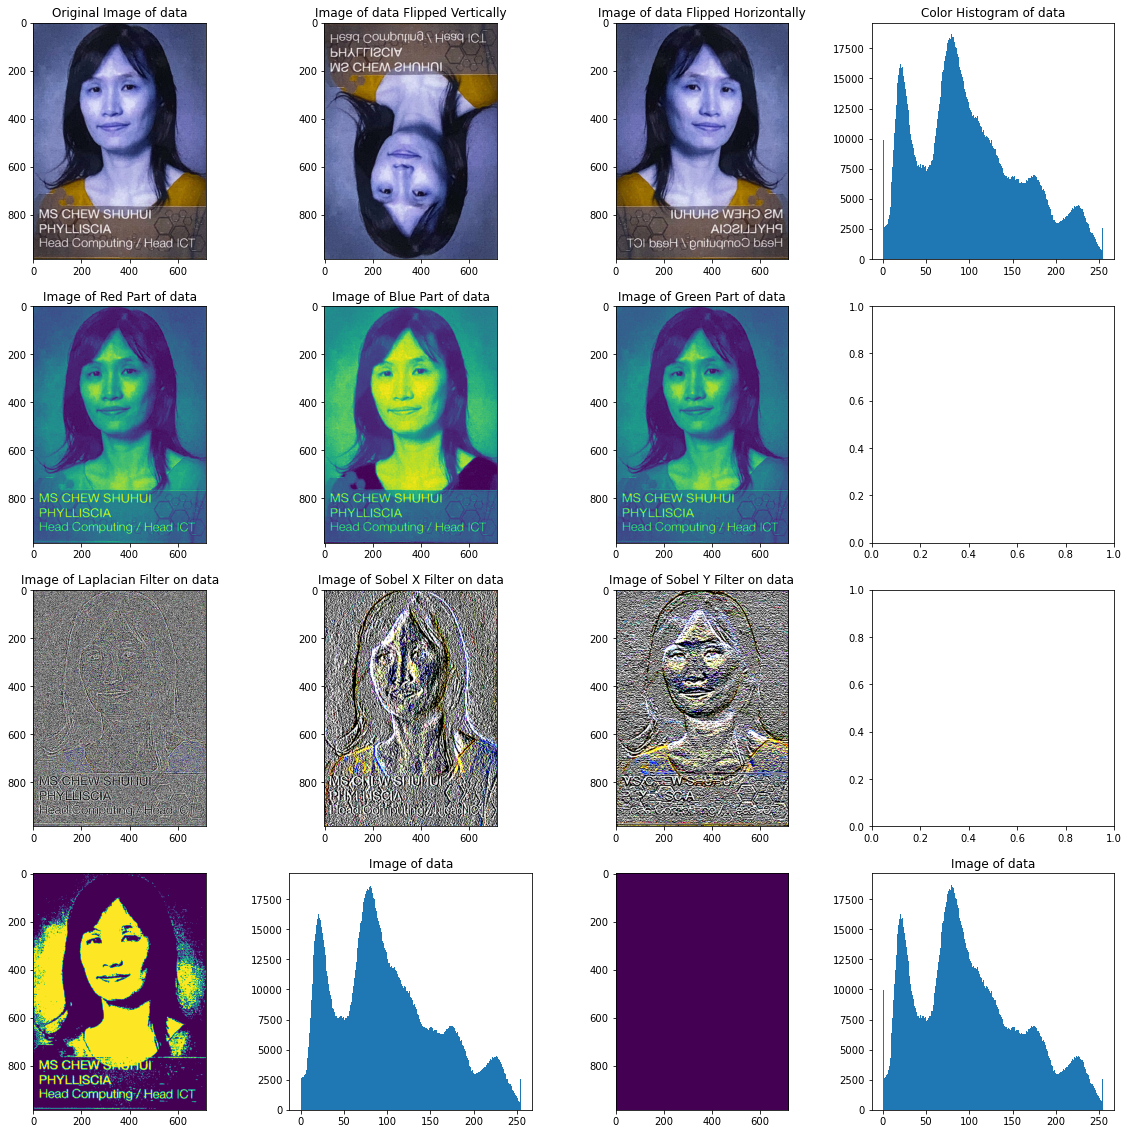

In [132]:
img_obj.createImageReport()

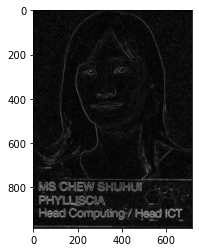

In [151]:
edges_img = img_obj.sobel().img
plt.imshow(edges_img, cmap='gray')

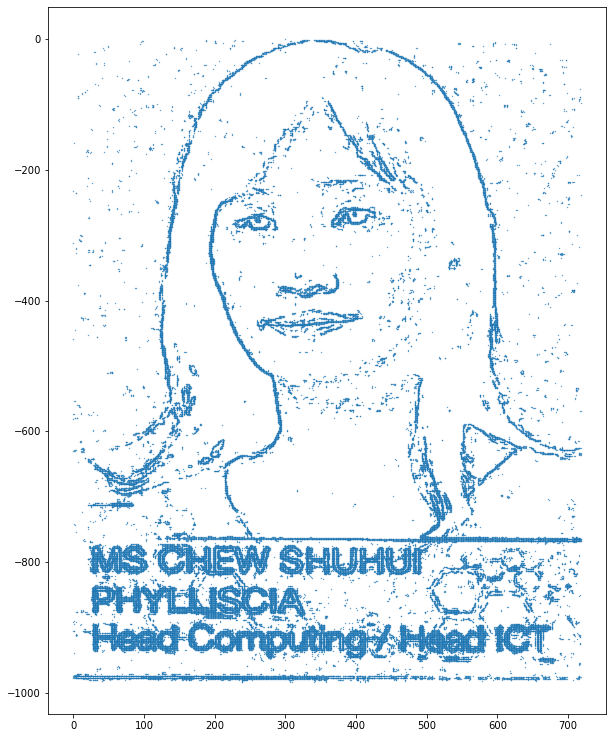

(0.07812741325670722, 5.279221387535551e-92)


In [206]:
plt.figure(figsize=(10,13))
x,y = np.argwhere(edges_img > 0.07).T
plt.scatter(y, -x, s=0.1)
plt.show()
print(stats.pearsonr(y, -x))